Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/11/09 13:12:43 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


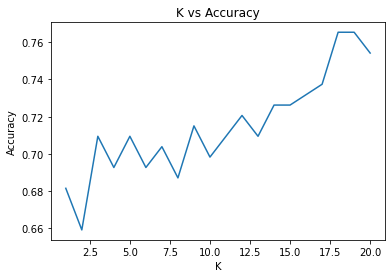

Best K value: 18
Confusion Matrix:
[[96  9]
 [33 41]]


In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql.types import StructType, StructField, DoubleType

# Initializing Spark session
spark = SparkSession.builder.appName("TitanicKNN").getOrCreate()

# Loading the dataset
train_df = spark.read.csv("/Users/adityakulkarni/Downloads/titanic/train.csv", header=True, inferSchema=True)
test_df = spark.read.csv("/Users/adityakulkarni/Downloads/titanic/test.csv", header=True, inferSchema=True)


# Feature selection
selected_features = ["Pclass", "Age", "Fare"]
X = train_df.select(*selected_features)
y = train_df.select("Survived")

# Handling missing values and convert to Pandas
X = X.fillna(0) 
X_pd = X.toPandas()

#Standard Scaler
def custom_standard_scaler(data):
    mean = np.mean(data, axis=0)
    std = np.std(data, axis=0)
    scaled_data = (data - mean) / std
    return scaled_data

# Converting Pandas DataFrame to a numpy array
X_pd_scaled = custom_standard_scaler(X_pd)
y_np = np.array(y.select("Survived").collect()).ravel()
X_np = np.array(X_pd_scaled)

# Spliting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_np, y_np, test_size=0.2, random_state=42)

# Determine the K value and create a visualization of accuracy
k_values = list(range(1, 21))
accuracies = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    accuracy = knn.score(X_test, y_test)
    accuracies.append(accuracy)

# Ploting the K values against accuracy
plt.plot(k_values, accuracies)
plt.xlabel('K')
plt.ylabel('Accuracy')
plt.title('K vs Accuracy')
plt.show()

# Selecting the best K value
best_k = k_values[np.argmax(accuracies)]

# Training the final model with the best K value
final_knn = KNeighborsClassifier(n_neighbors=best_k)
final_knn.fit(X_train, y_train)

# Evaluating using confusion matrix
y_pred = final_knn.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_pred)

# Model explanation
print(f"Best K value: {best_k}")
print("Confusion Matrix:")
print(conf_matrix)


## Confusion matrix 

1. True Positives (TP): 41 passengers survived and were correctly classified as survivors.
2. True Negatives (TN): 96 passengers did not survive and were correctly classified as non-survivors.
3. False Positives (FP): 9 passengers who did not survive were incorrectly classified as survivors.
4. False Negatives (FN): 33 passengers who survived were incorrectly classified as non-survivors.


Accuracy = (41 + 96) / (41 + 96 + 9 + 33) = 137 / 179 ≈ 0.7648

So, the accuracy of the model is approximately 0.7648, which is equivalent to 76.48%.

This means that the K-Nearest Neighbors (KNN) model correctly predicted the survival or non-survival of passengers in the Titanic dataset approximately 76.48% of the time